In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook')

In [2]:
import curveball

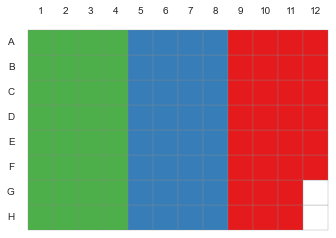

In [3]:
plate = pd.read_csv(r"D:/workspace/curveball_project/python/plate_templates/G-RG-R.csv")
fig,ax = curveball.plots.plot_plate(plate)

['G' 'RG' 'R' '0']


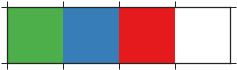

In [4]:
sns.palplot(plate.Color.unique())
print plate.Strain.unique()

In [5]:
filename = "D:/Google Drive/ex silico/tecan/Yoav_08022015_nolag.xlsx"
df = curveball.ioutils.read_tecan_xlsx(filename, ('OD','Green','Red'), max_time=14, plate=plate)

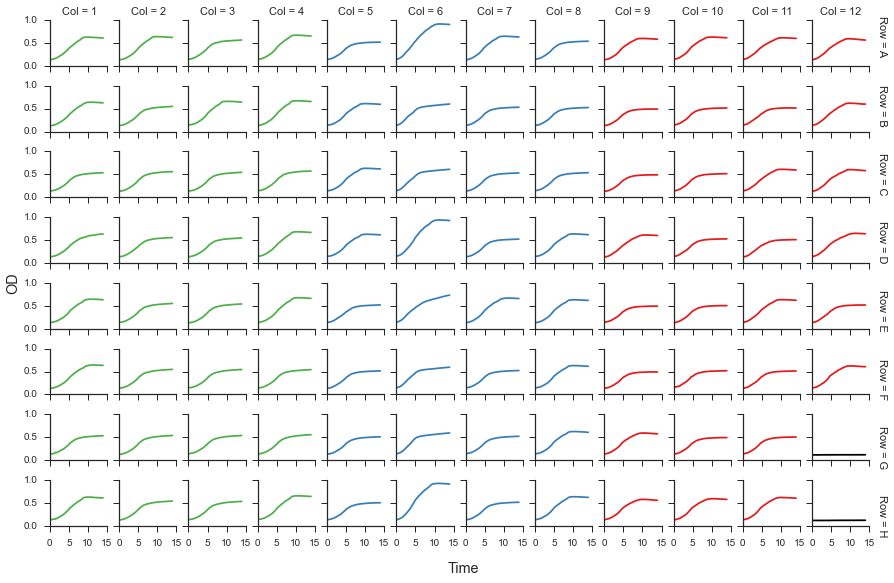

In [8]:
g = curveball.plots.plot_wells(df, 'Time', 'OD')

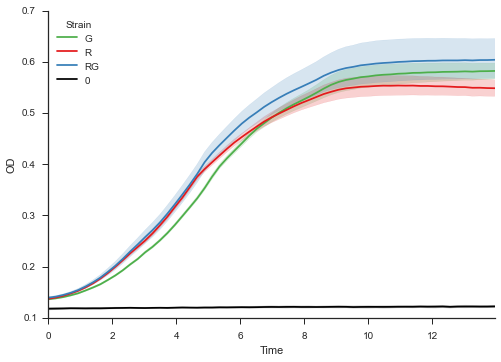

In [9]:
g = curveball.plots.tsplot(df)

[[Model]]
    Model(richards_function)
[[Fit Statistics]]
    # function evals   = 131
    # data points      = 61
    # variables        = 4
    chi-square         = 6.849
    reduced chi-square = 0.120
[[Variables]]
    y0:   0.13134016 +/- 0.000981 (0.75%) (init= 0.1393781)
    r:    0.22009256 +/- 0.005165 (2.35%) (init= 0.07495804)
    K:    0.59420035 +/- 0.008732 (1.47%) (init= 0.604425)
    nu:   5.82807405 +/- 1.405285 (24.11%) (init= 1)



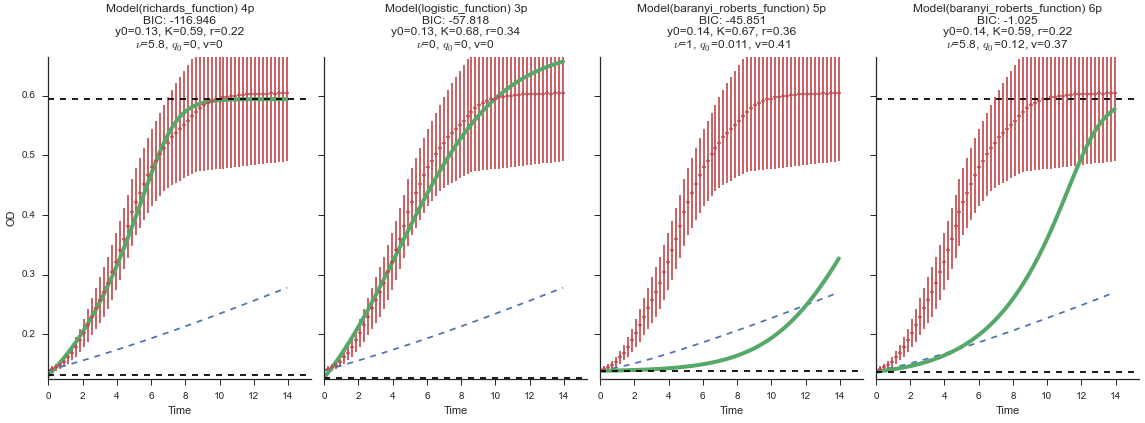

In [6]:
df_RG = df[df.Strain == 'RG']
models_RG,fig,ax = curveball.models.fit_model(df_RG)

In [8]:
models_well = {}
for well in df_RG.Well.unique():
    print well,
    df_well = df_RG[df_RG.Well == well]
    models_well[well] = curveball.models.fit_model(df_well, use_weights=False, PLOT=False, PRINT=False)[0]

A5 A6 A7 A8 B5 B6 B7 B8 C5 C6 C7 C8 D5 D6 D7 D8 E5 E6 E7 E8 F5 F6 F7 F8 G5 G6 G7 G8 H5 H6 H7 H8


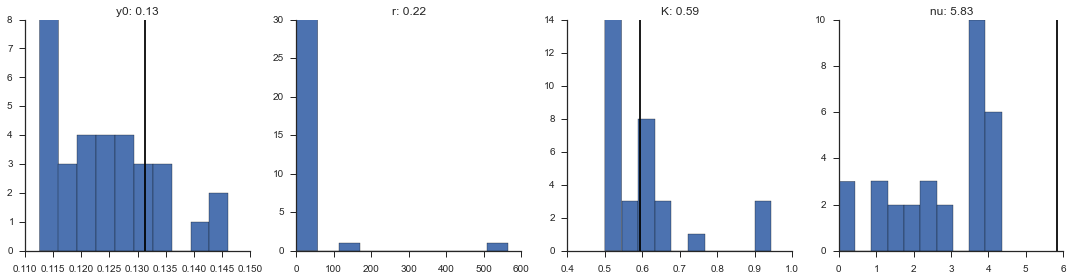

In [33]:
params = models_RG[0].params.values()
fig,ax = plt.subplots(1, len(params), figsize=(15,4))
for i,param in enumerate(params):
    if not param.vary: continue    
    v = [model_fit.params[param.name].value for well,model_fit in models_well.items() if param.name in model_fit.params]
    ax[i].axvline(x=param.value, color='k')
    ax[i].hist(v, bins=10)
    ax[i].set_title("%s: %.2f" % (param.name, param.value))
fig.tight_layout()
sns.despine()

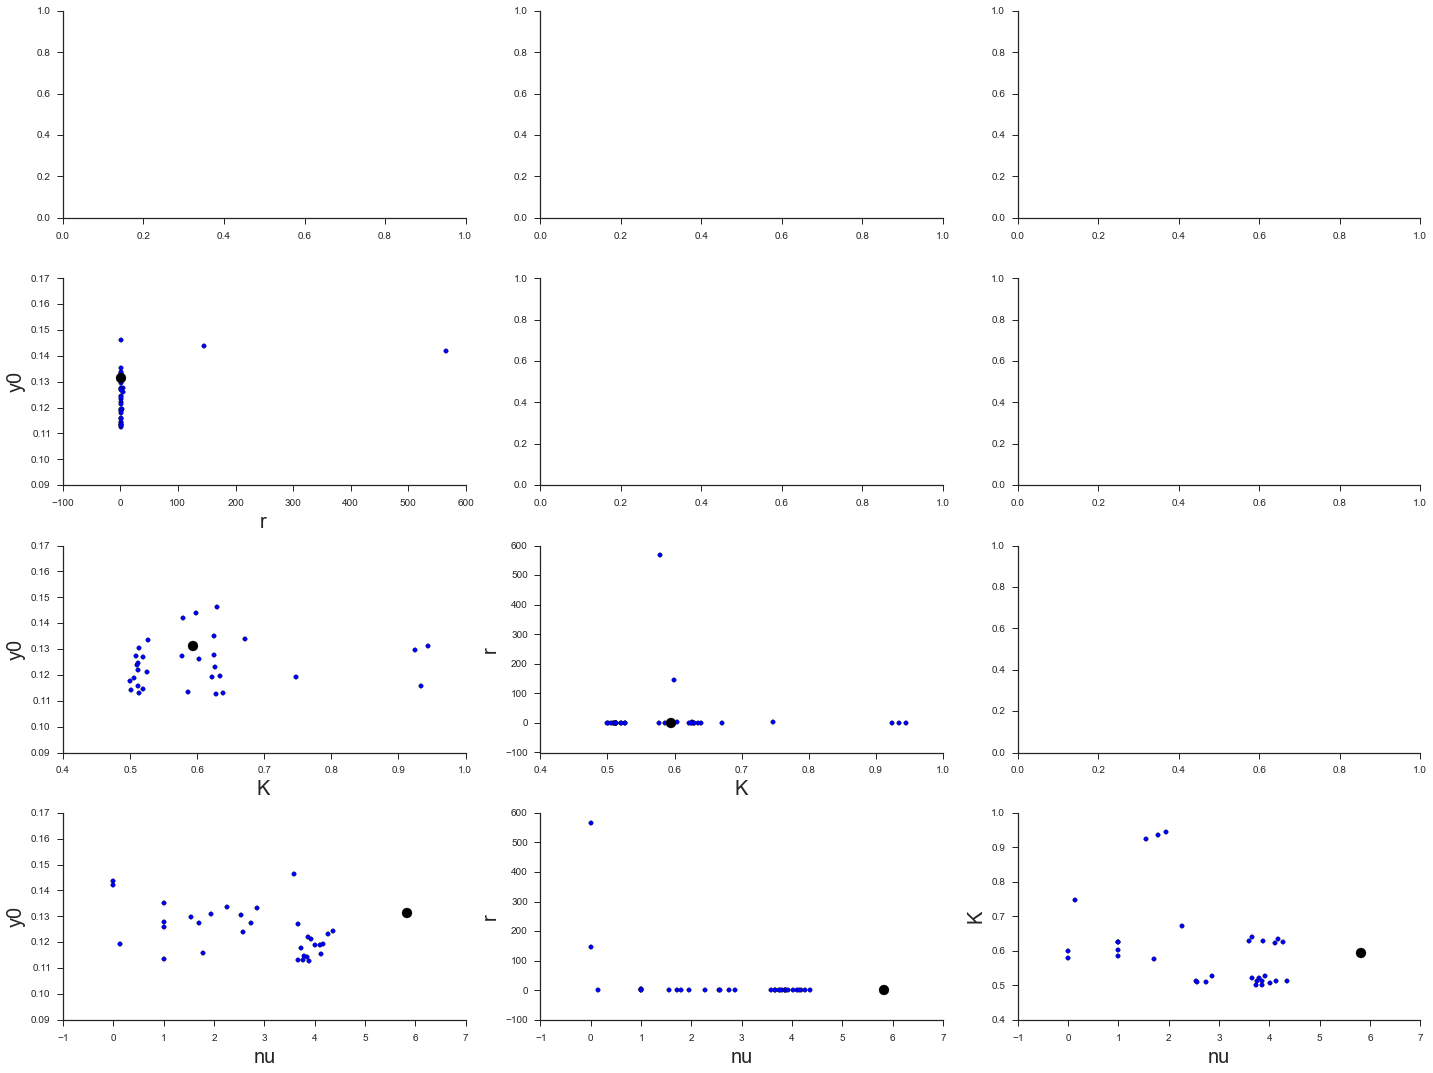

In [82]:
params = models_RG[0].params.values()
fig,ax = plt.subplots(len(params),(len(params)-1), figsize=(20,15))
for i,param in enumerate(params):
    if not param.vary: continue
    v = [model_fit.best_values.get(param.name, 1) for well,model_fit in models_well.items() ]
    for j,param2 in enumerate(params[:i]):
        v2 = [model_fit.best_values.get(param2.name, 1) for well,model_fit in models_well.items() ]
        ax[i,j].scatter(v, v2,  marker='o')
        ax[i,j].scatter(param.value, param2.value, marker='o', color='k', s=100)
        ax[i,j].set_xlabel(param.name, fontsize=20)
        ax[i,j].set_ylabel(param2.name, fontsize=20)        
fig.tight_layout()
sns.despine()

In [95]:
rows = []
for well,model_fit in models_well.items():
    d = dict(model_fit.best_values)
    d['Well'] = well
    rows.append(d)
params_df = pd.DataFrame(rows)

params_df.loc[np.isnan(params_df.v), 'v'] = 10
params_df.loc[np.isnan(params_df.q0), 'q0'] = 0
params_df.loc[np.isnan(params_df.nu), 'nu'] = 1

params_df.head()

,K,Well,nu,q0,r,v,y0
0,0.511797,G7,3.863891,0.000000,0.236003,10.000000,0.122001
1,0.578660,G6,0.000945,0.122242,566.368039,1.429838,0.141919
2,0.501357,G5,3.852697,0.000000,0.241695,10.000000,0.114079
3,0.621530,G8,4.102728,0.000000,0.239399,10.000000,0.118988
4,0.526149,C8,2.864856,1.000000,0.301215,0.720526,0.133343


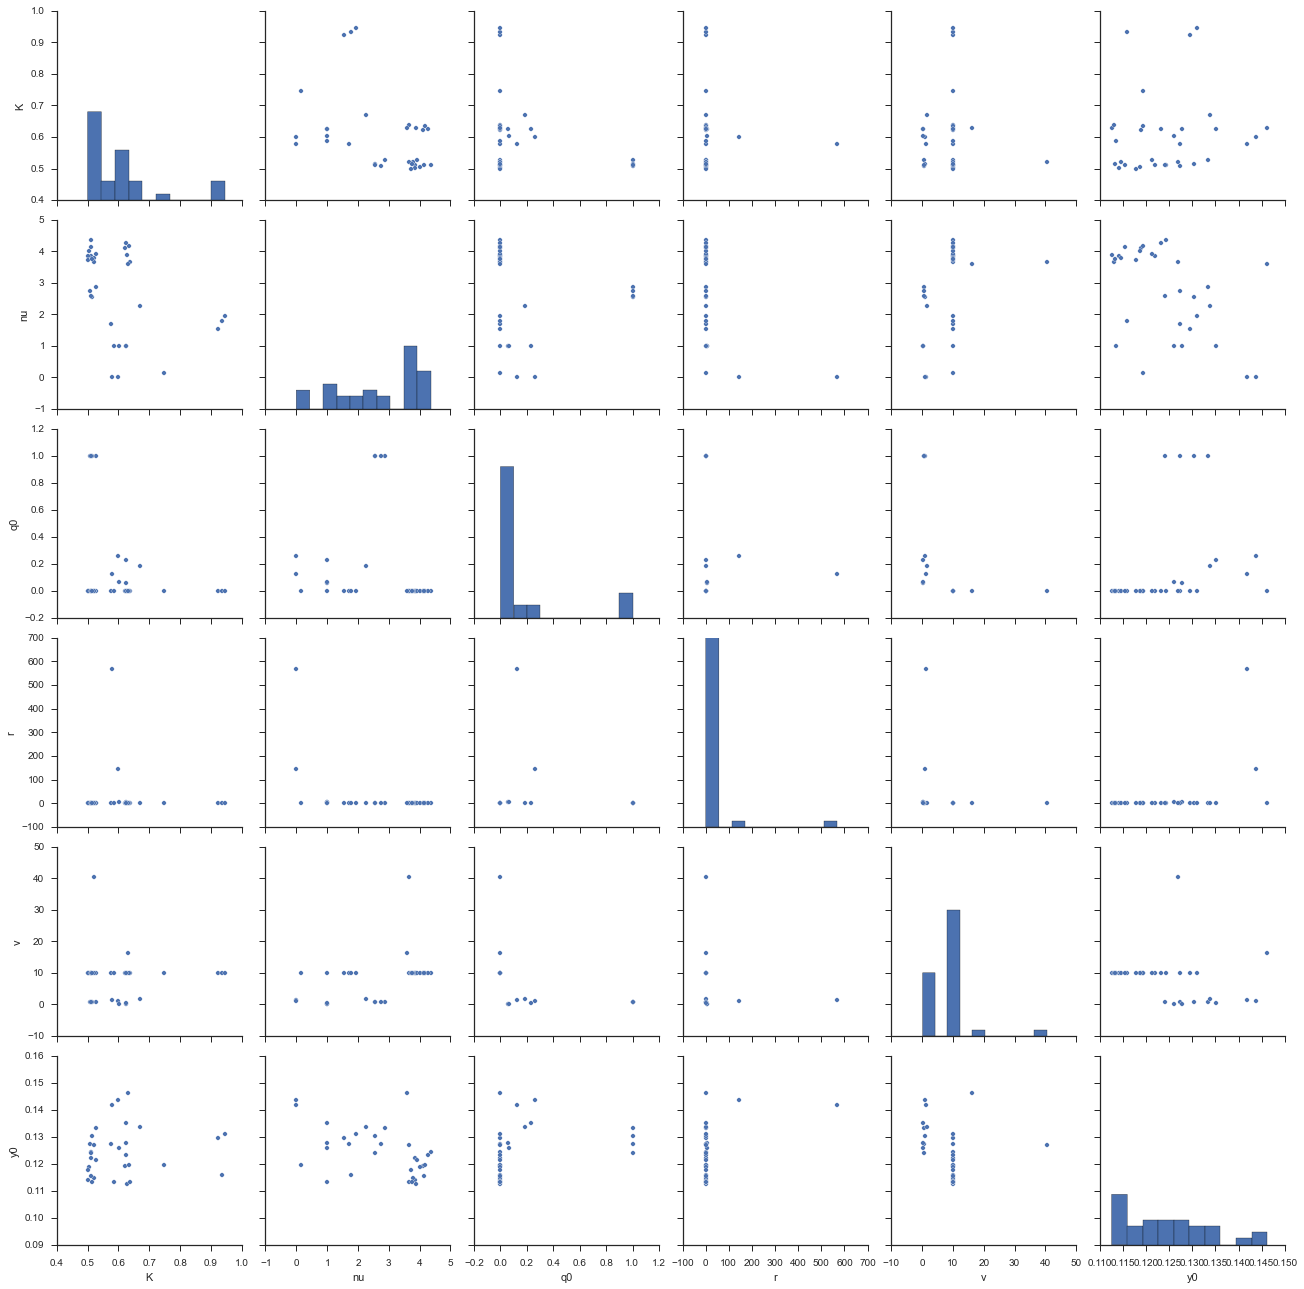

In [96]:
sns.pairplot(params_df, dropna=True)

## Outliers

In [55]:
outliers = [well for well,model_fit in models_well.items() if model_fit.best_values['r'] > 100]
print outliers
outliers += [well for well,model_fit in models_well.items() if model_fit.best_values.get('nu', 1) < 1]
print outliers
outliers += [well for well,model_fit in models_well.items() if model_fit.best_values['y0'] < models_RG[0].params['y0'].value/2]
print outliers
outliers += [well for well,model_fit in models_well.items() if model_fit.best_values['K'] > models_RG[0].params['K'].value*1.5]
print outliers

[u'G6', u'C6']
[u'G6', u'C6', u'G6', u'E6', u'C6']
[u'G6', u'C6', u'G6', u'E6', u'C6']
[u'G6', u'C6', u'G6', u'E6', u'C6', u'A6', u'H6', u'D6']


In [56]:
df_RG_cl = df_RG[~df_RG.Well.isin(outliers)]
df_RG_cl.Well.unique()

array([u'A5', u'A7', u'A8', u'B5', u'B6', u'B7', u'B8', u'C5', u'C7', u'C8',
       u'D5', u'D7', u'D8', u'E5', u'E7', u'E8', u'F5', u'F6', u'F7', u'F8',
       u'G5', u'G7', u'G8', u'H5', u'H7', u'H8'], dtype=object)

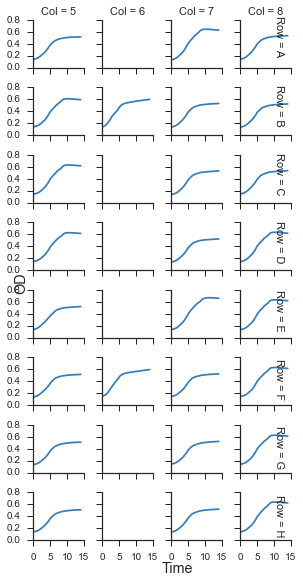

In [60]:
g = curveball.plots.plot_wells(df_RG_cl)
g.fig.tight_layout();

[[Model]]
    Model(baranyi_roberts_function)
[[Fit Statistics]]
    # function evals   = 243
    # data points      = 61
    # variables        = 6
    chi-square         = 0.567
    reduced chi-square = 0.010
[[Variables]]
    y0:   0.13781673 +/- 0.000386 (0.28%) (init= 0.1384346)
    r:    0.36179705 +/- 0.033502 (9.26%) (init= 0.07027)
    K:    0.56547674 +/- 0.001562 (0.28%) (init= 0.5641885)
    nu:   1.89482071 +/- 0.253627 (13.39%) (init= 1)
    q0:   0.24988611 +/- 0.018646 (7.46%) (init= 1)
    v:    1.23474414 +/- 0.134575 (10.90%) (init= 1)



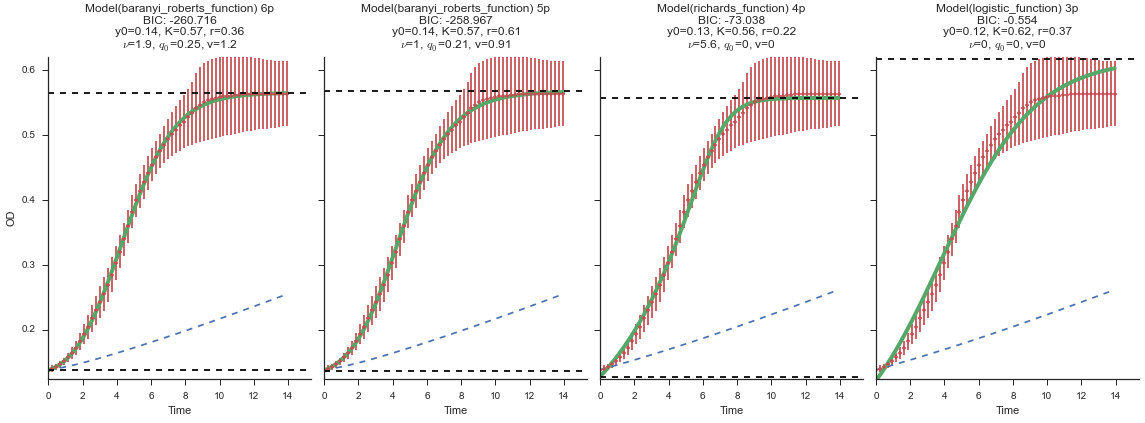

In [57]:
models_RG_cl,fig,ax = curveball.models.fit_model(df_RG_cl)